# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [54]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [76]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

shape is  (500, 10)
wx is  [-0.16739422 -0.03700181  0.1331139   0.15449577  0.01942624 -0.00220324
  0.02098136 -0.08691686 -0.27265559  0.11159177]
ewx is  [0.84586609 0.96367439 1.14238011 1.16706934 1.01961616 0.99779919
 1.02120302 0.91675331 0.76135496 1.11805634]
sum is  9.953772909614221
denom is  0.1004644177720905
(500, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3073, 10)
loss: 2.428784
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

because our class number is 10. when every probability is same, it means that probabilty(y) is also roughly 10%.
therefor loss would be something close to value -log(0.1)


In [77]:

a = [1.05348 ,   0.95902936 ,0.95800745, 0.89386195 ,0.78339884 ,1.22661456,
 0.90714429, 0.84470385, 0.97075295, 1.07305218]
print(sum(a))
1/sum(a)

9.67004543


0.10341213050536827

In [79]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.532895 analytic: 1.532895, relative error: 3.434719e-08
numerical: 0.083507 analytic: 0.083507, relative error: 3.484505e-07
numerical: -0.980348 analytic: -0.980348, relative error: 1.474727e-08
numerical: 1.232652 analytic: 1.232652, relative error: 4.460618e-08
numerical: 0.610764 analytic: 0.610764, relative error: 3.714975e-08
numerical: -4.468358 analytic: -4.468358, relative error: 9.141915e-09
numerical: -0.316283 analytic: -0.316283, relative error: 3.720849e-08
numerical: 0.747768 analytic: 0.747767, relative error: 1.229856e-07
numerical: -0.017282 analytic: -0.017282, relative error: 5.997584e-11
numerical: -3.025859 analytic: -3.025859, relative error: 9.133019e-10
numerical: 1.381683 analytic: 1.388255, relative error: 2.372563e-03
numerical: 1.558811 analytic: 1.551919, relative error: 2.215606e-03
numerical: 2.685844 analytic: 2.676971, relative error: 1.654468e-03
numerical: 2.070639 analytic: 2.063548, relative error: 1.715305e-03
numerical: -0.217033 ana

In [86]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.428784e+00 computed in 0.015369s
vectorized loss: 2.428784e+00 computed in 0.009110s
Loss difference: 0.000000
Gradient difference: 0.000000


In [100]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

pairs = []
for lr in learning_rates:
    for reg in regularization_strengths:
        pairs.append((lr, reg))
        
        
accuracy = []
models = []
for pair in pairs:
    lr = pair[0]
    reg = pair[1]
    # get gradient
    softmax = Softmax()
    softmax.train(X_train,y_train, lr, reg, 500, 200)
    y_train_pred = softmax.predict(X_train)
    y_pred = softmax.predict(X_val)
    acc = np.mean(y_val == y_pred)
    acc_train = np.mean(y_train == y_train_pred)
    results[pair] = (acc_train, acc)
    accuracy.append(acc)
    print('accuracy is ', acc,acc_train)
    models.append(softmax)
    
    

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))



accuracy is  0.321 0.31142857142857144
accuracy is  0.333 0.30957142857142855
accuracy is  0.341 0.3273469387755102
accuracy is  0.309 0.28761224489795917
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.311429 val accuracy: 0.321000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.309571 val accuracy: 0.333000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.327347 val accuracy: 0.341000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.287612 val accuracy: 0.309000


In [103]:
best_idx = np.argmax(accuracy)
best_val = accuracy[np.argmax(accuracy)]
best_pair = pairs[np.argmax(accuracy)]
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: 0.341000


In [110]:
best_softmax = models[best_idx]
best_softmax.train(X_train,y_train, best_pair[0], best_pair[1], 1500, 300)

[2.0393668497847197,
 2.0732508780424332,
 2.1060741277520516,
 2.107685928941685,
 2.099228860374194,
 2.094192404447536,
 2.088520448548989,
 2.1161857018169425,
 2.0728891077404583,
 2.07799168960467,
 2.092746182037024,
 2.0473340185868407,
 2.094160011282427,
 2.0630420970463015,
 2.0998371794055797,
 2.0857918219857616,
 2.141599045440766,
 2.0919523397318818,
 2.0994174285576133,
 2.145947318170997,
 2.114830168986626,
 2.0945594878519427,
 2.081015452659252,
 2.0813723481666333,
 2.0865598239516645,
 2.0547300774092383,
 2.0987851594671842,
 2.138989071996425,
 2.063323597789189,
 2.100994156064418,
 2.082343526464738,
 2.059929998973253,
 2.1120899375575672,
 2.1133627885170703,
 2.0984944546311937,
 2.073222779897245,
 2.139035866939915,
 2.1433859323208533,
 2.0655351538731384,
 2.130853674517996,
 2.121877635819007,
 2.135306129807163,
 2.0840709027138518,
 2.1197775297500265,
 2.1085357184600135,
 2.0558564992961412,
 2.1353141981357235,
 2.043353967739956,
 2.112416440197

In [111]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.327000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

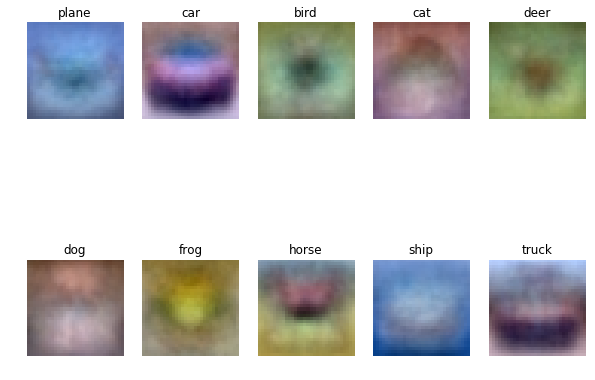

In [112]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])